In [1]:
import matplotlib.pyplot as plt
import numpy as np
from neurodsp.spectral import compute_spectrum

# Timescales & Spectral Knees

This notebook explores timescales, defined as the 'knee' of the log-log spectrum (or FWHM of linearly spaced spectrum). To start, unit impulse and Poisson point processes are shown, representing timescales at the shortest of durations (i.e. white noise).

In the second half of the notebook, various exponentially decaying kernels are convolved with the Poisson point process to simulate timescales. If the decay of the kernel is at the fastest extreme, the product will appoximate the original point process (white noise). At the slowest extreme, the decay of the kernel becomes so slow that spectra approaches 1/f and a timescale can not be measured without a long enough signal (e.g. NMDA timescales). To capture the widest range of timescales, the sampling rate and signal duration should approach infinity.

For more on quantifying timescales, see [here](https://voyteklab.com/timescale-methods/).

##  Discrete Unit Impulse

The discrete unit impulse (a specific case of the Kronecker delta) is defined as:

$$
\delta[n]=
\begin{cases}
  1, & \text{}\ n = 1 \\
  0, & \text{}\ n \neq 1
\end{cases}
$$

and represents a timescale that approcahes zero (${\tau \to 0}$) or as the knee frequency approaches infinity ($f_k \to \inf$). At this limit, the power spectra is white noise like.


## Poisson Point Process

The unit impulse may be extended to a Poisson point process, where the time between points (e.g 1's) follows a random exponential distribution:

$$
P[n]=
\begin{cases}
  1, & \text{}\ n \in \sum\limits_{}^{N} \lambda e^{\lambda x} \\
  0, & \text{otherwise}
\end{cases}
$$

where the summation term is the Poisson process and $\lambda$ is its the mean and standard deviation. 

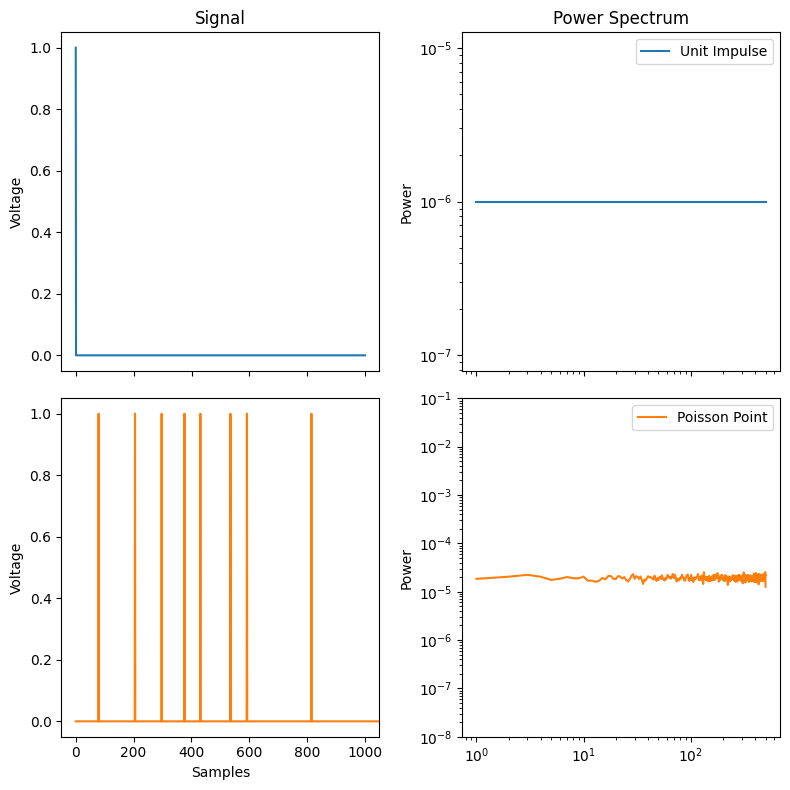

In [2]:
# Samling rate
fs = 1000

# Unit impulse
sig_unit = np.zeros(1000)
sig_unit[0] = 1
freqs_unit, powers_unit = compute_spectrum(sig_unit, fs, method='medfilt')

# Poisson Point
np.random.seed(0)
sig_poisson = np.zeros(100000)
inds = np.random.exponential(scale=100, size=100000).cumsum().astype(int)
inds = inds[np.where(inds < len(sig_poisson))[0]]
sig_poisson[inds] = 1

freqs_poisson, powers_poisson = compute_spectrum(sig_poisson, fs, method='welch')

# Plot
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))

axes[0, 0].plot(sig_unit)
axes[0, 1].loglog(freqs_unit[1:], powers_unit[1:], label='Unit Impulse')
axes[1, 0].plot(sig_poisson, color='C1')
axes[1, 1].loglog(freqs_poisson[1:], powers_poisson[1:], color='C1', label='Poisson Point')

# Limits
axes[1, 0].set_xlim(-50, 1050)
axes[1, 1].set_ylim(1e-8, 1e-1)

# Labels
axes[0, 0].set_xticklabels([])
axes[0, 1].set_xticklabels([])
axes[1, 0].set_xlabel('Samples')
axes[0, 0].set_ylabel('Voltage')
axes[1, 0].set_ylabel('Voltage')
axes[0, 1].set_ylabel('Power')
axes[1, 1].set_ylabel('Power')
axes[0, 0].set_title('Signal')
axes[0, 1].set_title('Power Spectrum')

# Legend
axes[0, 1].legend()
axes[1, 1].legend()

plt.tight_layout()

## Timescales

The Poisson point process may be convolved with an exponentially decaying kernel to produce timescales, quantified as knee frequencies (dashed). To demonstrate this, three kernels with varying decay rates are chosen:

1. Lower (fast) bound: the decay of the kernel is ~instanteous, producing a white or gaussian noise like spectrum (purple). High sampling rates are needed for timescales that approach this lower bound.
2. In between lower and upper bounds are timescales with more clearly defined spectral knees (red).
3. Upper (slow) bound: the decay of the kernel becomes ~ as long as the minimum of the frequency resolution, approaching 1/f dynamics (green). Longer signals are needed as the timescales approaches this bound. 

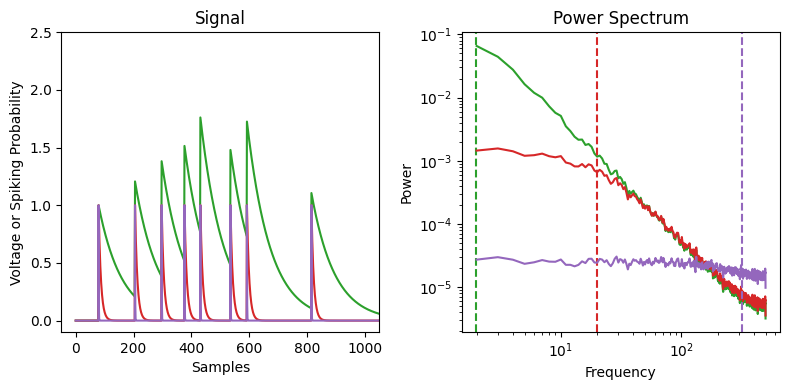

In [3]:
# Convolve the Poisson point process
#   with an exponentially decaying kernel
taus = np.array([t/fs for t in [80, 8, .5]])
knees = 1/(2*np.pi*taus)

sig_taus = np.zeros((len(taus), len(sig_poisson)))

for i, tau in enumerate(taus):
    kernel = np.exp(-np.arange(1000)/(tau*fs))
    sig_taus[i] = np.convolve(sig_poisson, kernel)[:len(sig_poisson)]

# Plot
fig, axes = plt.subplots(ncols=2, figsize=(8, 4))

colors = ['C2', 'C3', 'C4']
for s, c in zip(sig_taus, colors):
    axes[0].plot(s, color=c)

for s, t, c in zip(sig_taus, taus, colors):
    freqs_tau, powers_tau = compute_spectrum(s, fs, f_range=(1, 1200))
    axes[1].loglog(freqs_tau[1:], powers_tau[1:], color=c)
    axes[1].axvline(1/(t*2*np.pi), color=c, ls='--')
    
# Titles
axes[0].set_title('Signal')
axes[1].set_title('Power Spectrum')

# Labels
axes[0].set_ylabel('Voltage or Spiking Probability')
axes[0].set_xlabel('Samples')
axes[1].set_ylabel('Power')
axes[1].set_xlabel('Frequency')

axes[0].set_ylim(-.1, 2.5)
axes[0].set_xlim(-50, 1050)

plt.tight_layout()